In [1]:
import numpy as np
import scipy
import veloxchem as vlx

In [2]:
mol_str = """3

O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(mol_str)
basis = vlx.MolecularBasis.read(molecule, "cc-pVDZ", ostream=None)

In [3]:
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
norb = basis.get_dimensions_of_basis()
nocc = molecule.number_of_electrons() // 2
V_nuc = molecule.nuclear_repulsion_energy()

print("Number of orbitals:", norb)
print("Number of doubly occupied molecular orbitals:", nocc)
print(f"Nuclear repulsion energy (in a.u.): {V_nuc : 10.8f}")

Number of orbitals: 24
Number of doubly occupied molecular orbitals: 5
Nuclear repulsion energy (in a.u.):  9.34363816


In [5]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_drv.xcfun = "slater"

scf_drv.grid_level = 4
scf_drv.conv_thresh = 1.0e-6

scf_results = scf_drv.compute(molecule, basis)

In [6]:
print(f"Final DFT energy: {scf_drv.get_scf_energy() : 10.7f} Hartree")

Final DFT energy: -75.1874344 Hartree


In [7]:
# =============================================================
# integrals in AO basis
# =============================================================

# overlap matrix
S = vlx.compute_overlap_integrals(molecule, basis)

# one-electron Hamiltonian
T = vlx.compute_kinetic_energy_integrals(molecule, basis)

V = vlx.compute_nuclear_potential_integrals(molecule, basis)

h = T + V

# two-electron Hamiltonian
fock_drv = vlx.FockDriver()
g = fock_drv.compute_eri(molecule, basis)

# =============================================================
# DIIS convergence acceleration
# =============================================================


def c1diis(F_mats, e_vecs):
    n = len(e_vecs)

    # build DIIS matrix
    B = -np.ones((n + 1, n + 1))
    B[n, n] = 0

    for i in range(n):
        for j in range(n):
            B[i, j] = np.dot(e_vecs[i], e_vecs[j])

    b = np.zeros(n + 1)
    b[n] = -1
    w = np.matmul(np.linalg.inv(B), b)

    F_diis = np.zeros((norb, norb))
    for i in range(n):
        F_diis += w[i] * F_mats[i]

    return F_diis

In [8]:
grid_drv = vlx.GridDriver()

grid_drv.set_level(4)  # default level in VeloxChem

molgrid = grid_drv.generate(molecule)

weights = molgrid.w_to_numpy()

In [9]:
xc_drv = vlx.XCIntegrator()

# generate AOs on the grid points
chi_g = xc_drv.compute_gto_values(molecule, basis, molgrid)

In [10]:
def LDA_exchange(D):
    # determine the total density on the grid points
    G = np.einsum("ab,bg->ag", D, chi_g)
    n = 2 * np.einsum("ag,ag->g", chi_g, G)

    e_xc = -0.75 * (3 / np.pi) ** (1 / 3) * n ** (1 / 3)
    E_xc = np.dot(weights, n * e_xc)

    v_xc = -((3 / np.pi) ** (1 / 3)) * n ** (1 / 3)

    F_xc = np.zeros((norb, norb))

    for alpha in range(norb):
        for beta in range(alpha, norb):
            F_xc[alpha, beta] = np.dot(weights, chi_g[alpha, :] * v_xc * chi_g[beta, :])
            F_xc[beta, alpha] = F_xc[alpha, beta]

    return F_xc, E_xc

In [11]:
max_iter = 50
conv_thresh = 1e-6

e_vecs = []
F_mats = []

# initial guess from core Hamiltonian
epsilon, C = scipy.linalg.eigh(h, S)

print("iter       SCF energy   LDA exchange   Exact exchange   Error norm")

for iter in range(max_iter):
    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    F = h + 2 * J  # no exact exchange in the Fock matrix
    F_xc, E_xc = LDA_exchange(D)
    F += F_xc  # add LDA exchange
    F_mats.append(F)

    E = np.einsum("ij,ij->", 2 * h + 2 * J, D) + V_nuc
    E += E_xc

    # determine exact exchange for comparison
    K = np.einsum("ilkj,kl->ij", g, D)
    E_exact_exchange = np.einsum("ij,ij->", -K, D)

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vecs.append(e_mat.reshape(-1))
    error = np.linalg.norm(e_vecs[-1])
    print(f"{iter:>2d} {E:18.8f} {E_xc:14.8f} {E_exact_exchange:16.8f} {error:12.2e}")

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    F = c1diis(F_mats, e_vecs)
    epsilon, C = scipy.linalg.eigh(F, S)

iter       SCF energy   LDA exchange   Exact exchange   Error norm
 0       -67.80508830   -10.89381306     -11.93847705     3.14e+00
 1       -66.26792219    -6.28078058      -7.13537283     4.19e+00


 2       -74.99359878    -7.76615742      -8.60690061     8.13e-01
 3       -75.12110246    -7.90554682      -8.73394901     5.65e-01


 4       -75.13715465    -7.92293008      -8.75103380     4.94e-01
 5       -75.16585462    -7.99147909      -8.82023741     3.22e-01
 6       -75.18739992    -8.11598421      -8.94844153     1.24e-02
 7       -75.18742612    -8.11619778      -8.94863105     6.35e-03


 8       -75.18743428    -8.11849075      -8.95101979     7.61e-04
 9       -75.18743440    -8.11879444      -8.95133716     1.63e-06


10       -75.18743440    -8.11879427      -8.95133701     7.68e-08
SCF iterations converged!


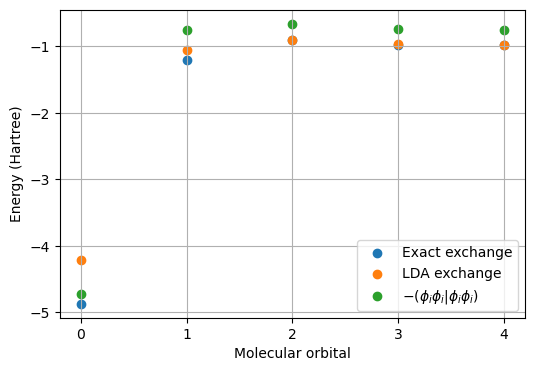

In [12]:
import matplotlib.pyplot as plt

F_xc_ii = []
K_ii = []
g_iiii = []

for i in range(nocc):
    F_xc_ii.append(np.einsum("a,b,ab->", C[:, i], C[:, i], F_xc))
    K_ii.append(np.einsum("a,b,ab->", C[:, i], C[:, i], K))
    g_iiii.append(np.einsum("a,b,c,d,abcd->", C[:, i], C[:, i], C[:, i], C[:, i], g))

LDA_x_ii = 1.5 * np.array(F_xc_ii)
HF_x_ii = -np.array(K_ii)
g_iiii = np.array(g_iiii)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes(xticks=range(5))

ax.scatter(range(nocc), HF_x_ii, label="Exact exchange")
ax.scatter(range(nocc), LDA_x_ii, label="LDA exchange")
ax.scatter(range(nocc), -g_iiii, label=r"$-(\phi_i\phi_i | \phi_i\phi_i)$")

ax.legend(fontsize=10)
ax.grid(True)

plt.xlabel("Molecular orbital", fontsize=10)
plt.ylabel("Energy (Hartree)", fontsize=10)
plt.show()

In [13]:
print("SIE percentage part of exchange energy")
for i in range(5):
    print(f"{i} {-g_iiii[i] / HF_x_ii[i] * 100 : 6.1f}%")

SIE percentage part of exchange energy
0   97.0%
1   62.8%
2   73.1%
3   76.5%
4   76.7%


In [14]:
print("Comparison of LDA and HF exchange energies")
for i in range(5):
    print(
        f"{i} {LDA_x_ii[i] / HF_x_ii[i] * 100 : 6.1f}% {LDA_x_ii[i] - HF_x_ii[i] : 6.2f} a.u."
    )

Comparison of LDA and HF exchange energies
0   86.4%   0.66 a.u.
1   87.5%   0.15 a.u.
2   99.4%   0.01 a.u.
3   98.9%   0.01 a.u.
4   99.7%   0.00 a.u.
